In [2]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import os
from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [6]:
limitTrees =OrderedDict()
dataCards = OrderedDict()

limitTrees10 =OrderedDict()
dataCards10 = OrderedDict()

version = '/V1p17/v1/v9/'
dc_version = 'v1'

nrechit = 130

dphi = 'dPhiCluster0p75'

bdt_name = 'cut_based_v4'

limitDir = os.environ['HOME']+'/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine_gdituri/limitTrees/'+version+'/'+bdt_name+'/'+dc_version+'/'
dataCardDir = os.environ['HOME']+'/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine_gdituri/datacards/'+version+'/'+bdt_name+'/'+dc_version+'/'

lumi = 137000

ctaus = np.array([10, 30, 40, 50, 60, 80, 100, 200, 300, 500, ])

samples = ['ggH_HToSS_SToEE_ms0p1_pl500']

for sample in samples:
    limitTrees[sample] = {}
    dataCards[sample] = {}
    for ct in ctaus:
        limitTrees[sample][ct] = limitDir + 'higgsCombine.'+sample+'_ctau'+str(ct)+'mm_nRechit'+ str(nrechit)+ dphi+'.AsymptoticLimits.mH120.root'
        dataCards[sample][ct] = dataCardDir + sample+'_ctau'+str(ct)+'mm_nRechit'+ str(nrechit)+ dphi+'.txt'

        
norms = []
limits = {}
for i,m in enumerate(limitTrees.keys()):
    for j, k in enumerate(limitTrees[m].keys()):

        T = uproot.open(limitTrees[m][k])['limit']
        line = open(dataCards[m][k], "r").readline()
        signal_norm = float(line.split(" ")[3])
        if signal_norm == 0:limit_temp = np.ones((6,))*100000
        else:limit_temp = np.array(T.array('limit'))/signal_norm
        
        if j == 0: limits[m] = limit_temp
        else: limits[m] = np.vstack((limits[m], limit_temp))
    limits[m] = np.array(limits[m])
print(ctaus)




[ 10  30  40  50  60  80 100 200 300 500]


# load atlas limit

In [7]:
file_dir = os.environ['HOME']+'/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/data/limits_others/'
ms1_40 = file_dir + 'atlas_mh125_mx40_ms1.csv'
ms2_40 = file_dir + 'atlas_mh125_mx40_ms2.csv'
id55 = file_dir + 'atlas_mh125_mx55_id.csv'
comb40 = file_dir + 'atlas_mh125_mx40_id_cr_ms2.csv'
jingyu = file_dir + 'jingyu_mh125_mx55_95p9ifb.csv'
ms_40 = file_dir + 'atlas_mh125_mx40_ms.csv'
ms_15 = file_dir + 'atlas_mh125_mx15_ms.csv'

ms_40 = np.genfromtxt(ms_40, delimiter=',')
ms_15 = np.genfromtxt(ms_15, delimiter=',')
ms1_40 = np.genfromtxt(ms1_40, delimiter=',')
ms2_40 = np.genfromtxt(ms2_40, delimiter=',')
id55 = np.genfromtxt(id55, delimiter=',')
comb40 = np.genfromtxt(comb40, delimiter=',')
jingyu = np.genfromtxt(jingyu, delimiter=',')
print(comb40.shape)

(130, 2)


# Plot

137 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


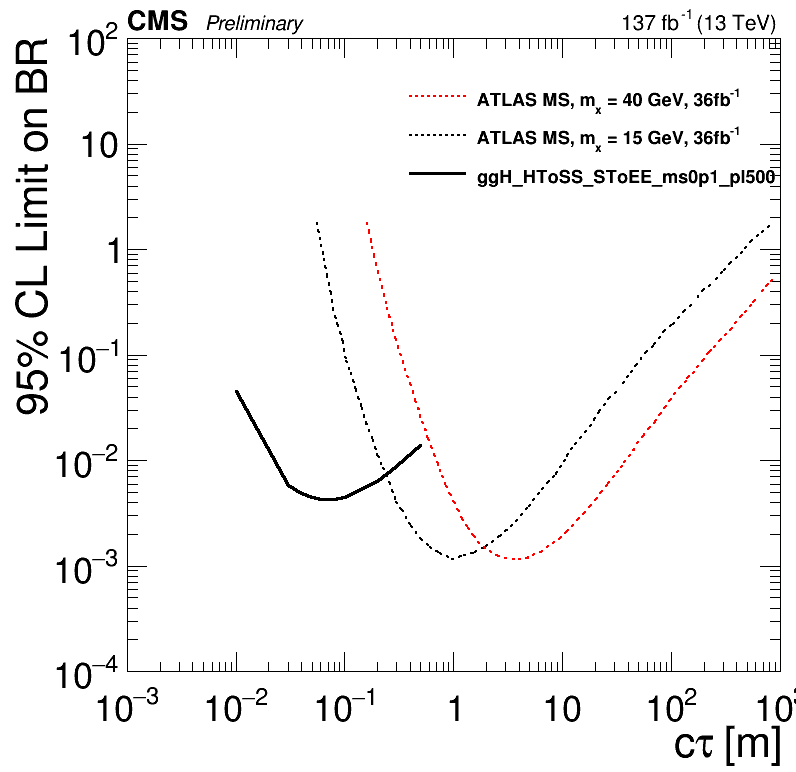

In [12]:
import os
leg = rt.TLegend(0.5,0.75,0.9,0.9)
    
leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)



c = rt.TCanvas('c','c', 800, 800)
# Plotting ncsc
start_t = time.time()

rt.gStyle.SetOptFit(1011)
# for i,k in enumerate(tree_bkg.keys()):
br = 1
ctaus_m = ctaus/1000
h_others = {}
h = {}
h_others['ms_15'] = create_TGraph(ms_15[:,0],ms_15[:,1],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
h_others['ms_40'] = create_TGraph(ms_40[:,0],ms_40[:,1],  axis_title=['c#tau [m]', '95% CL Limit on BR'])


leg.AddEntry(h_others['ms_40'], "ATLAS MS, m_{x} = 40 GeV, 36fb^{-1}", 'L')
leg.AddEntry(h_others['ms_15'], "ATLAS MS, m_{x} = 15 GeV, 36fb^{-1}", 'L')
for i, m in enumerate(limits.keys()):
    cond = limits[m][:,2] < 1
    h[m] = create_TGraph(ctaus_m[cond], limits[m][:,2][cond],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
    h[m].SetLineColor(std_color_list[i])
    h[m].SetLineWidth(3)
    h[m].GetXaxis().SetLimits(0.001,1000.0)
    h[m].GetYaxis().SetRangeUser(1e-4,100)
    h[m].GetXaxis().SetTitleOffset(1)
    leg.AddEntry(h[m], m, "L")
    h[m].Draw('LA' if i == 0 else 'Lsame')

for i, k in enumerate(h_others.keys()): 
    h_others[k].SetLineWidth(2)
    h_others[k].SetLineColor(std_color_list[i])
    h_others[k].SetLineStyle(2)
    h_others[k].Draw('Lsame')


tdrstyle.setTDRStyle()
CMS_lumi.cmsText     = "CMS"
iPos = 0
CMS_lumi.writeExtraText = True
CMS_lumi.extraText   = "Preliminary"

if( iPos==0 ): CMS_lumi.relPosX = 0.12
CMS_lumi.CMS_lumi(c, 4, 0)

leg.Draw()
c.SetLogy()
c.SetLogx()

c.Draw()


# limit for different mass points

[0.01 0.03 0.04 0.05 0.06 0.08 0.1  0.2  0.3  0.5 ]
137 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


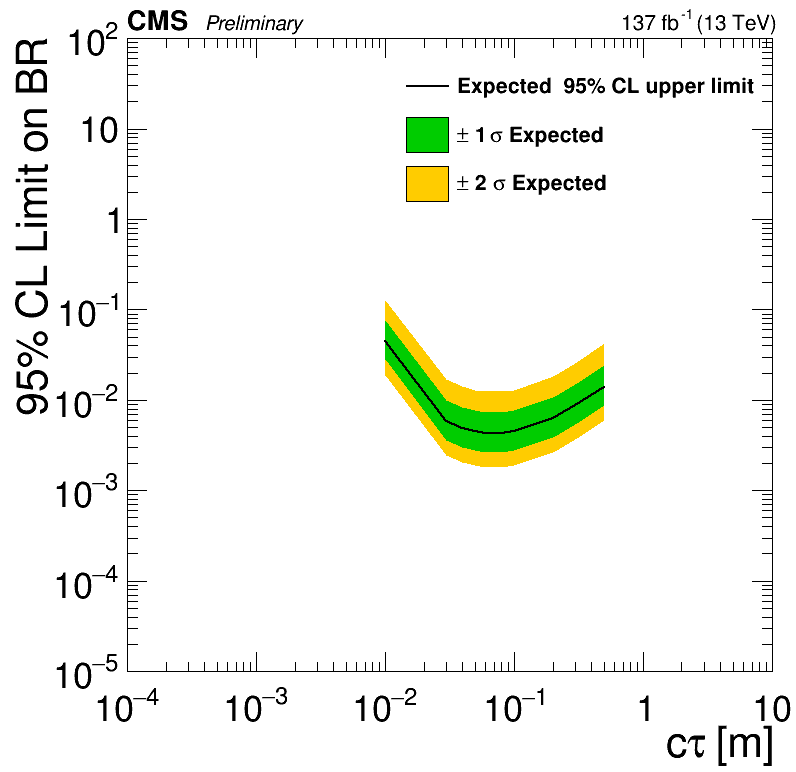

In [15]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot



# Plotting ncsc
start_t = time.time()

rt.gStyle.SetOptFit(1011)
# for i,k in enumerate(tree_bkg.keys()):
br = 1
ctaus_m = ctaus/1000
print(ctaus_m)
# print(limits[:,2])
h_others = {}
h = {}
h_exp1sig = {}
h_exp2sig = {}

for m in limits.keys():


    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.5,0.73,0.80,0.92)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    cond = limits[m][:,2] < 1
    h[m] = create_TGraph(ctaus_m[cond], limits[m][:,2][cond],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
   

    h_exp1sig[m] = create_TGraph(np.hstack((ctaus_m[cond], np.flip(ctaus_m[cond]))), np.hstack((limits[m][:,1][cond], np.flip(limits[m][:,3][cond]))))
    h_exp2sig[m] = create_TGraph(np.hstack((ctaus_m[cond], np.flip(ctaus_m[cond]))), np.hstack((limits[m][:,0][cond], np.flip(limits[m][:,4][cond]))))
#
    leg.AddEntry(h[m], "Expected  95% CL upper limit", "L")
    leg.AddEntry(h_exp1sig[m], "#pm 1 #sigma Expected", 'F')
    leg.AddEntry(h_exp2sig[m], "#pm 2 #sigma Expected", 'F')
    h[m].SetLineColor(std_color_list[0])
    h[m].SetLineWidth(2)
    h_exp1sig[m].SetFillColor(417)
    h_exp2sig[m].SetFillColor(800)
    h[m].GetXaxis().SetLimits(0.0001,10.0)
    h[m].GetYaxis().SetRangeUser(1e-5,100)
    h[m].GetXaxis().SetTitleOffset(1)

    h[m].Draw('LA')
    h_exp2sig[m].Draw( 'Fsame')
    h_exp1sig[m].Draw('Fsame')
    h[m].Draw('Lsame')

    tdrstyle.setTDRStyle()
    CMS_lumi.cmsText     = "CMS"
    iPos = 0
    CMS_lumi.writeExtraText = True
    CMS_lumi.extraText   = "Preliminary"

    iPos = 0
    if( iPos==0 ): CMS_lumi.relPosX = 0.12
    CMS_lumi.CMS_lumi(c, 4, 0)
    leg.Draw()
    c.SetRightMargin(0.03)
    c.SetLogy()
    c.SetLogx()

    c.Draw()
# print(time.time()-start_t)